In [1]:
from ema_workbench.analysis import prim
from ema_workbench import load_results
from sklearn import preprocessing
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns

In [2]:
ACTOR = "genscen_Overijssel_50000_12-06-2021-02-18-42.tar.gz"

In [3]:
experiments, outcomes = load_results("simulation/generated/" + ACTOR)
dike_model, planning_steps = get_model_for_problem_formulation("Overijssel")
uncertainties = [uncertainty.name for uncertainty in dike_model.uncertainties]
x = experiments[uncertainties]
outcomes_df = pd.DataFrame(outcomes)

In [4]:
outcomes_df.columns.values.tolist()

['Gorssel and Deventer Expected Annual Damage',
 'Gorssel and Deventer Expected Number of Deaths',
 'Gorssel and Deventer Total Costs']

In [5]:
DAMAGE = outcomes_df.columns[0]
DEATHS = outcomes_df.columns[1]
COSTS = outcomes_df.columns[2]

C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left=x0, right=x1)
C:\Users\Lisette\anaconda3\envs\adsim\lib\site-packages\ema_workbench\analysis\regional_sa.py:162: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_

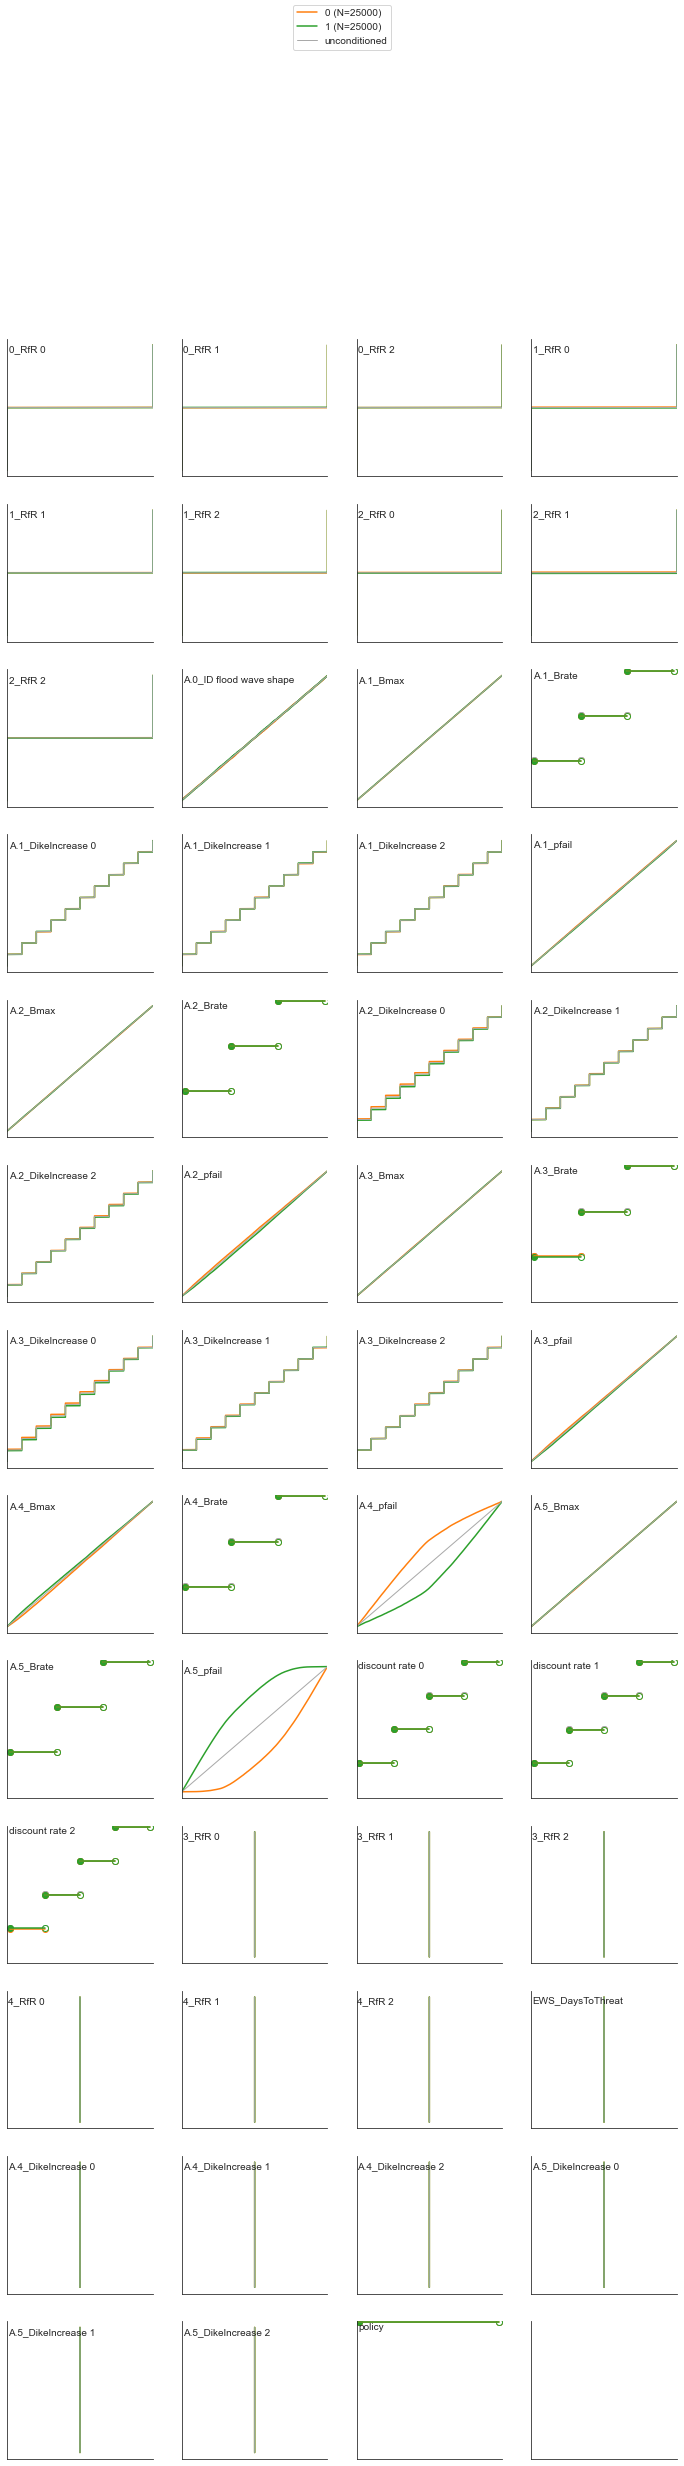

In [6]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style('white')

# model is the same across experiments
x = experiments.copy()
x = x.drop('model', axis=1)
y = outcomes[DEATHS] >  np.percentile(a=outcomes_df[DEATHS], q=50)
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
damage_scaled = min_max_scaler.fit_transform(pd.DataFrame(outcomes[DAMAGE]).values)
deaths_scaled = min_max_scaler.fit_transform(pd.DataFrame(outcomes[DEATHS]).values)
scaled = (damage_scaled + deaths_scaled)/2

In [8]:
outcomes_df["Scaled"] = scaled
SCALED = 'Scaled'

In [9]:
DAMAGE

'Gorssel and Deventer Expected Annual Damage'

In [11]:
outcomes_df.describe(percentiles=np.arange(0, 1, 0.1))

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,Scaled
count,5.000000e+04,50000.000000,50000.0,50000.000000
mean,2.238156e+08,0.185281,0.0,0.152460
std,2.662215e+08,0.236627,0.0,0.187645
min,0.000000e+00,0.000000,0.0,0.000000
0%,0.000000e+00,0.000000,0.0,0.000000
10%,3.141319e+07,0.021130,0.0,0.020010
20%,5.190175e+07,0.030364,0.0,0.030327
30%,7.143141e+07,0.044249,0.0,0.042565
40%,9.542010e+07,0.061027,0.0,0.057316
50%,1.228096e+08,0.073162,0.0,0.074426


Obviously, without any policies inplace, there also aren't any costs for Gorssel.

In [12]:
prim_algs = {}
for outcome in [DAMAGE, DEATHS, SCALED]:
    #code block below performs a rotation of data
#     x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
#     x_categorical = x.select_dtypes(include=pd.CategoricalDtype)
#     rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, conditional(outcome))
#     rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)
#     rotated_x.columns = x_numeric.columns.tolist() + x_categorical.columns.tolist()
#     x = rotated_x
    
    prim_algs[outcome] = prim.Prim(x,  outcomes_df[outcome] > np.percentile(a=outcomes_df[outcome], q=90), threshold=0.8)

In [13]:
boxes = {}
for key in [DAMAGE, DEATHS, SCALED]:
    print(key)
    boxes[key] = prim_algs[key].find_box()

Gorssel and Deventer Expected Annual Damage
Gorssel and Deventer Expected Number of Deaths
Scaled


Gorssel and Deventer Expected Annual Damage


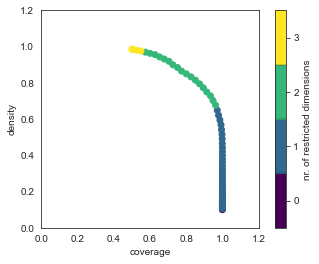

Gorssel and Deventer Expected Number of Deaths


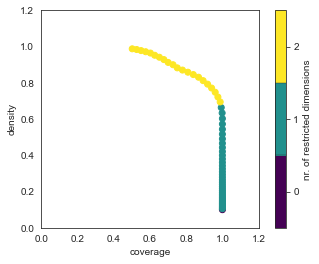

Scaled


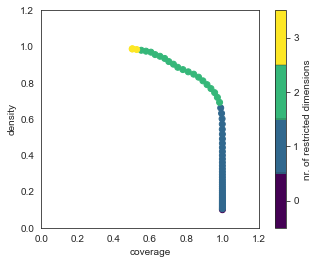

In [14]:
for key, box in boxes.items():
    print(key)
    box.show_tradeoff()
    plt.show()

# Trying around to find the right box

## Damage

In [21]:
box_id=44
BOX = DAMAGE

coverage      0.8512
density     0.814545
id                44
mass          0.1045
mean        0.814545
res_dim            2
Name: 44, dtype: object

             box 44                                          
                min       max                       qp values
A.5_pfail  0.000019  0.115677                     [-1.0, 0.0]
A.4_pfail  0.098869  0.999986  [1.5503341633259234e-19, -1.0]



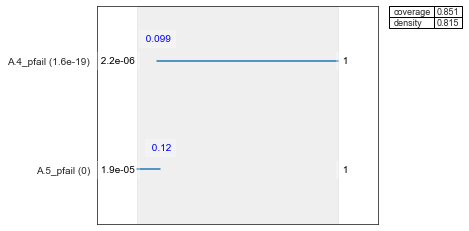

In [22]:
boxes[BOX].inspect(box_id)
boxes[BOX].inspect(box_id, style='graph')
plt.show()

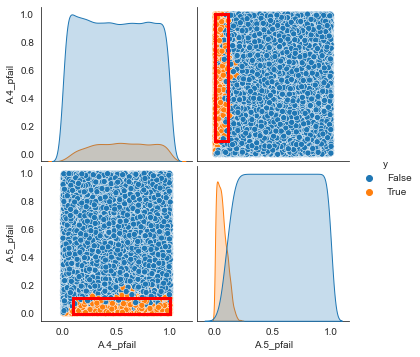

In [23]:
boxes[BOX].select(box_id)
boxes[BOX].show_pairs_scatter()
plt.show()

In [24]:
lims = boxes[BOX].box_lims[box_id]

In [25]:
limits = pd.DataFrame(data={"outcome": ["damage"], "min": [lims["A.4_pfail"][0]], "max" :  [lims["A.4_pfail"][1]]})

In [26]:
limits

,outcome,min,max
0,damage,0.098869,0.999986


## Deaths

In [29]:
box_id=43
BOX = DEATHS

coverage      0.8936
density     0.812216
id                43
mass         0.11002
mean        0.812216
res_dim            2
Name: 43, dtype: object

             box 43                                        
                min       max                     qp values
A.5_pfail  0.000019  0.121759                   [-1.0, 0.0]
A.4_pfail  0.098666  0.999986  [1.57364289090277e-24, -1.0]



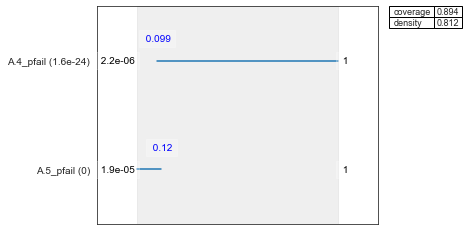

In [30]:
boxes[BOX].inspect(box_id)
boxes[BOX].inspect(box_id, style='graph')
plt.show()

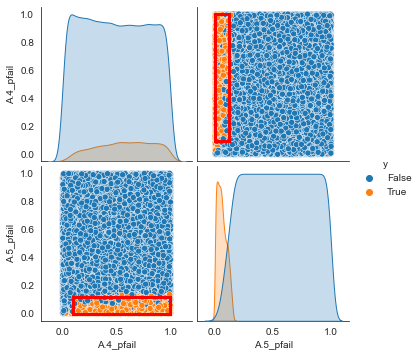

In [31]:
boxes[BOX].select(box_id)
boxes[BOX].show_pairs_scatter()
plt.show()

In [32]:
lims2 = boxes[BOX].box_lims[box_id]

In [33]:
limits = pd.concat([limits, pd.DataFrame(data={"outcome": ["deaths"], "min": [lims2["A.4_pfail"][0]], "max" :  [lims2["A.4_pfail"][1]]})], axis=0)

## Scaled

In [39]:
box_id=43
BOX = SCALED

coverage      0.8924
density     0.811125
id                43
mass         0.11002
mean        0.811125
res_dim            2
Name: 43, dtype: object

             box 43                                         
                min       max                      qp values
A.5_pfail  0.000019  0.121759                    [-1.0, 0.0]
A.4_pfail  0.098666  0.999986  [9.085801522985585e-24, -1.0]



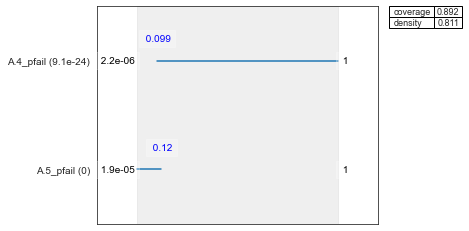

In [40]:
boxes[BOX].inspect(box_id)
boxes[BOX].inspect(box_id, style='graph')
plt.show()

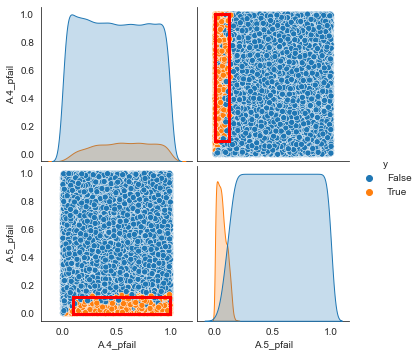

In [41]:
boxes[BOX].select(box_id)
boxes[BOX].show_pairs_scatter()
plt.show()

In [87]:
lims = boxes[BOX].box_lims[box_id]

In [88]:
limits = pd.concat([limits, pd.DataFrame(data={"outcome": ["scaled"], "min": [lims["A.4_pfail"][0]], "max" :  [lims["A.4_pfail"][1]]})], axis=0)

In [92]:
limits =limits.reset_index(drop=True)

# Visualisation

In [95]:
limits

,outcome,min,max
0,damage,0.000014,0.099266
1,deaths,0.000014,0.115819
2,scaled,0.000014,0.110023


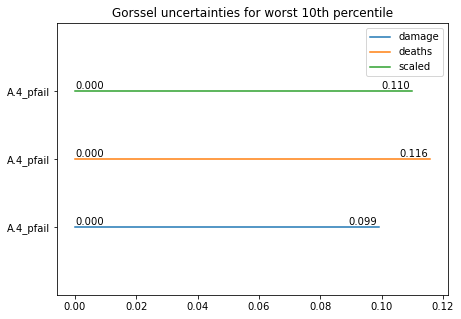

In [110]:
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)
for index in limits.index:
    plt.plot([limits.loc[index]["min"],limits.loc[index]["max"]], [index,index])
    ax.annotate('{:.3f}'.format(limits.loc[index]["min"]),xy=(limits.loc[index]["min"],index +0.03))
    ax.annotate('{:.3f}'.format(limits.loc[index]["max"]),xy=(limits.loc[index]["max"]-0.01,index +0.03))
ax.grid(False)
ax.set_ylim([-1,3])
plt.legend(limits["outcome"].values)    
plt.yticks([0, 1,2], ["A.4_pfail"]*3)
plt.title("Gorssel uncertainties for worst 10th percentile")
plt.show()